# 455 Final Version 2
This version uses a dataset with larger images for birds (Rhode Island backyard birds), and resizes images to 128x128

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset, random_split, Subset, ConcatDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/homebrew/anaconda3/envs/cse446/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Datasets

In [2]:
# import os
# import shutil

# dir_root =  "/content/gdrive/My Drive/CSE455 Project2/"
# dir_training =  "/content/gdrive/My Drive/CSE455 Project2/training"
# dir_local_dataset = "/content/dataset"
# dataset_name = "dataset.zip"

# # Create project training dir, if not exists
# if not os.path.exists(dir_training):
#   os.makedirs(dir_training)

# # Copy over dataset to local
# if not os.path.exists('dataset'):
#   if not os.path.exists(dir_root + dataset_name):
#     print("Error: dataset zip is not in Google Drive")
#   else:
#     os.chdir("/content/")
#     print("Copying dataset to runtime env...")
#     shutil.copy(dir_root + dataset_name, "./" + dataset_name)
#     print("Unzipping...")
#     !unzip \*.zip && rm *.zip
# print("Data available in runtime")

# for github repo
dir_local_dataset = "../dataset"
dir_training = "../models"

In [3]:
train_split = 0.9

data_classes = np.array(["bird", "squirrel"])

def load_dataset(batch_size, train_split=0.8, val_split=0.1, rand_transform=False):
  # Test_split will be the difference between train_split+val_split and 1

  # Load the dataset and return train, test loaders
  data_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
  ])

  if rand_transform: # Pad, flip, and crop
    train_transform = transforms.Compose([
      transforms.Resize((128,128)),
      transforms.RandomCrop(128, 16),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor()
    ])
  else:
    train_transform = data_transform
    
  # todo: implement train&test transform

  dataset = torchvision.datasets.ImageFolder(root=dir_local_dataset, transform=data_transform)
  
  n_train = int(train_split * len(dataset))
  n_val = int(val_split * len(dataset))
  n_test = len(dataset) - n_train - n_val

  train_dataset, val_dataset, test_dataset =  random_split(dataset, [n_train, n_val, n_test])
    
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  print(f'Training set: {n_train} images')
  print(f'Validation set: {n_val} images')
  print(f'Test set: {n_test} images')


  return (train_loader, val_loader, test_loader)

## Obselete Loading Code

In [ ]:
# obselete
def load_cifar():
  # load in datasets
  train_cifar10 = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=torchvision.transforms.ToTensor())
  test_cifar10 = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=torchvision.transforms.ToTensor())
  train_cifar100 = torchvision.datasets.CIFAR100("./data", train=True, download=True, transform=torchvision.transforms.ToTensor())
  test_cifar100 = torchvision.datasets.CIFAR100("./data", train=False, download=True, transform=torchvision.transforms.ToTensor())

  # get bird images from CIFAR-10
  train_bird_idxs = np.where(np.array(train_cifar10.targets) == train_cifar10.class_to_idx["bird"])[0]
  test_bird_idxs = np.where(np.array(test_cifar10.targets) == train_cifar10.class_to_idx["bird"])[0]

  # get squirrel images from CIFAR-100
  train_squirrel_idxs = np.where(np.array(train_cifar100.targets) == train_cifar100.class_to_idx["squirrel"])[0]
  test_squirrel_idxs = np.where(np.array(test_cifar100.targets) == train_cifar100.class_to_idx["squirrel"])[0]

  # subset birds and squirrels from CIFAR datasets to concatenate with other datasets
  train_cifar10_birds = Subset(train_cifar10, train_bird_idxs)
  test_cifar10_birds = Subset(test_cifar10, test_bird_idxs)
  train_cifar100_squirrels = Subset(train_cifar100, train_squirrel_idxs)
  test_cifar100_squirrels = Subset(test_cifar100, test_squirrel_idxs)

  return train_cifar10_birds, test_cifar10_birds, train_cifar100_squirrels, test_cifar100_squirrels

train_cifar10_birds, test_cifar10_birds, train_cifar100_squirrels, test_cifar100_squirrels = load_cifar()

In [ ]:
# download squirrels, animals-10, and squirrel-data dataset into Google Drive
downloading_data = False
if downloading_data:
  import os
  os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/CSE455 Project"

  %cd /content/gdrive/My Drive/CSE455 Project/squirrels
  !kaggle datasets download -d harrybaines/squirrels
  !unzip \*.zip  && rm *.zip

  %cd /content/gdrive/My Drive/CSE455 Project/animals-10
  !kaggle datasets download -d alessiocorrado99/animals10
  !unzip \*.zip  && rm *.zip

  %cd /content/gdrive/My Drive/CSE455 Project/squirrel-data
  !kaggle datasets download -d sheldenshi/squirrel-data
  !unzip \*.zip  && rm *.zip
  
def load_animals_10():
  # load squirrel images from animals-10 dataset, resizing to 32x32x3
  data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()
  ])

  trainset = torchvision.datasets.ImageFolder(root='/content/gdrive/My Drive/CSE455 Project/animals-10/raw-img/', transform=data_transform)

  squirrel_idxs = np.where(np.array(trainset.targets) == trainset.class_to_idx["scoiattolo"])[0]

  return Subset(trainset, squirrel_idxs)

animals_10_squirrels = load_animals_10()

In [ ]:
def load_imagescv():
  # load squirrel images from animals-10 dataset, resizing to 32x32x3
  data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()
  ])

  trainset = torchvision.datasets.ImageFolder(root='/content/gdrive/My Drive/CSE455 Project/imagescv/', transform=data_transform)

  return Subset(trainset, np.ones(len(trainset)))

imagescv_squirrels = load_imagescv()

In [ ]:
def load_squirrelsdataset():
  # load squirrel images from animals-10 dataset, resizing to 32x32x3
  data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()
  ])

  trainset = torchvision.datasets.ImageFolder(root='/content/gdrive/My Drive/CSE455 Project/Squirrel_Classifier_Data/', transform=data_transform)

  return Subset(trainset, np.ones(len(trainset)))

squirrelsdataset = load_squirrelsdataset()

In [ ]:
from torch.utils.data.distributed import Dataset
# combine all train and test subsets for squirrels and birds since we are using multiple datasets

squirrel_datasets = [animals_10_squirrels, train_cifar100_squirrels, test_cifar100_squirrels, imagescv_squirrels, squirrelsdataset]
bird_datasets = [train_cifar10_birds, test_cifar10_birds]

for bird_dataset in bird_datasets:
  bird_dataset.dataset.targets = np.full(len(bird_dataset.dataset.targets), 0)

for sq_dataset in squirrel_datasets:
  sq_dataset.dataset.targets = np.full(len(sq_dataset.dataset.targets), 1)

squirrels_data = Subset(all_dataset)
birds_data = ConcatDataset(bird_datasets)

# resize sets to be the same size
smallest_set_sz = min(len(squirrels_data), len(birds_data))
squirrels_data = random_split(squirrels_data, [smallest_set_sz, len(squirrels_data)-smallest_set_sz])[0]
birds_data = random_split(birds_data, [smallest_set_sz, len(birds_data)-smallest_set_sz])[0]

5548
5548


['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol']

# Model

In [4]:
class SquirrelNet(nn.Module):
  def __init__(self):
    super(SquirrelNet, self).__init__()

    # conv: |output| = (|input| + 2padding - |filter|)/stride + 1

    # (32+2*1-3)/1 + 1 = 31+1 = 32

    self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1, bias=False)     # (3,32,32)->(16,32,32)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1, bias=False)    # (16,32,32)->(32,32,32)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1, bias=False)    # (32,32,32)->(64,32,32)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, 3, stride=1, padding=1, bias=False)   # (64,16,16)->(128,16,16)
    self.bn4 = nn.BatchNorm2d(128)
    self.conv5 = nn.Conv2d(128, 256, 3, stride=1, padding=1, bias=False)   # (64,16,16)->(128,16,16)
    self.bn5 = nn.BatchNorm2d(256)
    self.conv6 = nn.Conv2d(256, 512, 3, stride=1, padding=1, bias=False)   # (64,16,16)->(128,16,16)
    self.bn6 = nn.BatchNorm2d(512)
    self.fc1 = nn.Linear(512, 2)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2)
    x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2)
    x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2)
    x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2)
    x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2)
    x = F.max_pool2d(F.relu(self.bn6(self.conv6(x))), kernel_size=4)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    return x

# create new model
model = SquirrelNet()

In [64]:
# load existing model
modelNum = 2
state = torch.load(dir_training + 'model-%d.pkl'%(modelNum))
model.load_state_dict(state['net'])

<All keys matched successfully>

# Training

Training set: 10622 images
Validation set: 1327 images
Test set: 1329 images


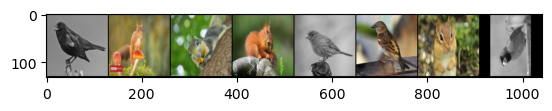

Labels:       bird    squirrel    squirrel    squirrel        bird        bird    squirrel        bird


In [5]:
# setup dataloaders
BATCH_SIZE = 128
train_loader, val_loader, test_loader = load_dataset(BATCH_SIZE)

# from tutorial: show some dataset images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images[:8]
labels = labels[:8]

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print("Labels:" + ' '.join('%11s' % data_classes[labels[j]] for j in range(8)))

In [6]:
LR = 0.01
MOMENTUM = 0.9
DECAY = 0.0005
EPOCHS = 20
BATCH_SIZE = 128

In [7]:
def accuracy(mode, loader):
  # Adapted from tutorial2
  correct = 0
  total = 0
  with torch.no_grad():
        for i, data in enumerate(loader, 0):
          images, labels = data[0].to(device), data[1].to(device)
          outputs = mode(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

In [8]:
def train(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, momentum=MOMENTUM, weight_decay=DECAY):
  model.to(device)

  # set up loss and optimization
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

  training_losses = []

  for epoch in range(epochs):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      training_losses.append(loss.item())

      if i % 20 == 19:
          print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss/20))
          running_loss = 0.0
    print("Epoch %d. Validation accuracy=%f" %(epoch+1, accuracy(model, val_loader)))

  return training_losses

In [9]:
print("Number of model parameters:",  sum(p.numel() for p in model.parameters()))

Number of model parameters: 1574802


In [ ]:
losses = train(model, train_loader, val_loader, lr=0.1, epochs=15, weight_decay=0)
losses = train(model, train_loader, val_loader, lr=0.01, epochs=15, weight_decay=0.0001)
losses = train(model, train_loader, val_loader, lr=0.005, epochs=10, weight_decay=0.0005)
losses = train(model, train_loader, val_loader, lr=0.001, epochs=10, weight_decay=0.0001)

In [10]:
losses = train(model, train_loader, val_loader, lr=0.01, epochs=10, weight_decay=0.000)

[1,    20] loss: 0.659
[1,    40] loss: 0.357
[1,    60] loss: 0.350
[1,    80] loss: 0.267
Epoch 1. Validation accuracy=0.948003
[2,    20] loss: 0.191
[2,    40] loss: 0.215
[2,    60] loss: 0.151
[2,    80] loss: 0.140
Epoch 2. Validation accuracy=0.948757
[3,    20] loss: 0.095
[3,    40] loss: 0.109
[3,    60] loss: 0.080
[3,    80] loss: 0.075
Epoch 3. Validation accuracy=0.975132
[4,    20] loss: 0.054
[4,    40] loss: 0.048
[4,    60] loss: 0.046
[4,    80] loss: 0.054
Epoch 4. Validation accuracy=0.981914
[5,    20] loss: 0.035
[5,    40] loss: 0.033
[5,    60] loss: 0.026
[5,    80] loss: 0.031
Epoch 5. Validation accuracy=0.974378
[6,    20] loss: 0.020
[6,    40] loss: 0.012
[6,    60] loss: 0.012
[6,    80] loss: 0.020
Epoch 6. Validation accuracy=0.976639
[7,    20] loss: 0.014
[7,    40] loss: 0.009
[7,    60] loss: 0.011
[7,    80] loss: 0.007
Epoch 7. Validation accuracy=0.977393
[8,    20] loss: 0.003
[8,    40] loss: 0.003
[8,    60] loss: 0.002
[8,    80] loss: 0.00

In [11]:
print("Train accuracy: %f. Test accuracy: %f" %(accuracy(model, train_loader), accuracy(model, test_loader)))

Train accuracy: 1.000000. Test accuracy: 0.985704


In [12]:
# save the model
modelNum = 3
state = {'net': model.state_dict()}
torch.save(state, dir_training + 'model-%d.pkl'%(modelNum))

In [14]:
# convert current notebook to python script (if we want to run script on another server)
!jupyter nbconvert --to script train_script.ipynb

[NbConvertApp] Converting notebook train_script.ipynb to script
[NbConvertApp] Writing 12529 bytes to train_script.py
